### Import Libraries

In [1]:
from generators import *
from callbacks import WriteBatchResultsToCSV
from models import unet
from keras.callbacks import ModelCheckpoint,CSVLogger
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
from copy import deepcopy

plt.rcParams['figure.figsize'] = [10, 5]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def dirSize(whatDir):
    oldDir = os.getcwd()
    os.chdir(whatDir)
    cwd = os.getcwd()
    length = 0
    dirs = os.listdir()
    for d in dirs:
        path = cwd + "/" + d + "/data/"
        subdirs = os.listdir(path)
        for s in subdirs:
            length += len(os.listdir(path + s))
    
    os.chdir(oldDir)
    return length

### Common Variables

In [4]:
# path to data on aws
path = "/home/ubuntu/project/data/groundcover2016/"
model_path = "/home/ubuntu/project/model_checkpoints/"
# Firm Training variables
width = 256
height = 256
input_shape = (width,height,3)

# get length of the training and validation sets
train_size = dirSize(path + "train")
validate_size = dirSize(path + "validate")

### Training Parameters

In [2]:
# path to data on aws
path = "../../data/size1/"

# Firm Training variables
input_shape = (2048,1152,3)
# Variables to tweak
steps_per_epoch = 200
epochs = 5
batch_size = 5

# define parameters to build the model
params = {
    'n_classes' : 1,
    'optimizer' : 'sgd',
    'lr' : 0.01,
    'dropout' : 0.5,
    'conv_depth' : 2,
    'input_shape' : input_shape,
    'activation' : "relu",
    'init_w' : "he_normal",
    'output_activation' = 'sigmoid'
}

### Load in Model and Generator

In [3]:
# load in model 
model = unet(params)
# initialize generator
trainGenerator = generateData(path,"train",save_dir = False,batch_size = batch_size)
validateGenerator = generateData(path,"validate",save_dir = False,batch_size = batch_size)

/home/ubuntu/project/src/segmentation/unet_keras.py:126: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs,output = outputs)


### Train Model

This model takes images of size 2048 x 1152 as inputs. This causes the convolutional layers to be shallow because the model and images cannot be fit into the RAM of the graphics card otherwise

In [ ]:
model_checkpoint = ModelCheckpoint(path + '/models/unet_train.hdf5', monitor='loss',verbose=1, save_best_only=True)
logger = CSVLogger(path + "/models/unet.csv")
output = model.fit_generator(generator = trainGenerator,
                    validation_data = validateGenerator,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = 160,
                    epochs = epochs,
                    use_multiprocessing = True,
                    callbacks =[model_checkpoint, logger])

Found 1011 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Epoch 1/5
199/200 [============================>.] - ETA: 4s - loss: 0.4980 - acc: 0.8813Found 168 images belonging to 1 classes.
Found 168 images belonging to 1 classes.
200/200 [==============================] - 1660s 8s/step - loss: 0.4974 - acc: 0.8814 - val_loss: 0.3960 - val_acc: 0.8839

Epoch 00001: loss improved from inf to 0.49735, saving model to ../../data/size1//models/unet_train.hdf5
Epoch 2/5
199/200 [============================>.] - ETA: 4s - loss: 0.3769 - acc: 0.8827Found 168 images belonging to 1 classes.
Found 168 images belonging to 1 classes.
200/200 [==============================] - 1614s 8s/step - loss: 0.3766 - acc: 0.8828 - val_loss: 0.3640 - val_acc: 0.8839

Epoch 00002: loss improved from 0.49735 to 0.37694, saving model to ../../data/size1//models/unet_train.hdf5
Epoch 3/5
199/200 [============================>.] - ETA: 4s - loss: 0.3582 - acc: 0.8856Found 168 images belong

In [4]:
# Do more training
params = {
    'n_classes' : 2,
    'lr' : 0.01,
    'dropout' : 0.5,
    'conv_depth' : 2,
    'input_shape' : (2048,1152,3),
    'activation' : "relu",
    'init_w' : "he_normal",
    'old_weights' : path + "/models/unet_train.hdf5"
}
model = unet(params)
model_checkpoint = ModelCheckpoint(path + '/models/unet_train.hdf5', monitor='loss',verbose=1, save_best_only=True)
logger = CSVLogger(path + "/models/unet.csv")
output = model.fit_generator(generator = trainGenerator,
                    validation_data = validateGenerator,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = 160,
                    epochs = 1,
                    use_multiprocessing = True,
                    callbacks =[model_checkpoint, logger])

/home/ubuntu/project/src/segmentation/unet_keras.py:126: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs,output = outputs)


Found 1011 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Epoch 1/1
199/200 [============================>.] - ETA: 4s - loss: 0.3610 - acc: 0.8831Found 168 images belonging to 1 classes.
Found 168 images belonging to 1 classes.
200/200 [==============================] - 1644s 8s/step - loss: 0.3608 - acc: 0.8832 - val_loss: 0.3593 - val_acc: 0.8839

Epoch 00001: loss improved from inf to 0.36081, saving model to ../../data/size1//models/unet_train.hdf5


### Train on Split images

In [8]:
# path to data on aws
path = "/home/ubuntu/project/data/"

# Firm Training variables
input_shape = (256,256,3)

# get length of the training and validation sets
train_size = len(os.listdir(path + '/train/data'))
validate_size = len(os.listdir(path + '/validate/data'))

# Variables to tweak
epochs = 5
batch_size = 15
steps_per_epoch = round(train_size/batch_size)
validation_steps = round(validate_size/batch_size)


# define parameters to build the model
params = {
    'n_classes' : 1,
    'lr' : 0.01,
    'optimizer' : 'SGD',
    'loss': 'binary_crossentropy',
    'dropout' : 0.0,
    'conv_depth' : 64,
    'input_shape' : input_shape,
    'activation' : "relu",
    'init_w' : "he_normal",
    'output_activation': 'sigmoid'
}
trainGenParams = {
    'path' : path,
    'which_data': 'train',
    'n_classes' : 1,
    'batch_size': batch_size,
    'target_size': (256,256)
}

validateGenParams = {
    'path' : path,
    'which_data': 'validate',
    'n_classes' : 1,
    'batch_size': batch_size,
    'target_size': (256,256)
}

m_checkpoint = model_path + 'unet/unet_train_all_reshaped.hdf5'
log_checkpoint = model_path + 'unet/unet_all_reshaped.csv'

In [4]:
# define the callbacks
model_checkpoint = ModelCheckpoint(m_checkpoint, monitor='loss',verbose=1, save_best_only=True)
logger = CSVLogger(log_checkpoint)
# create generators and model
trainGenerator = generateData(trainGenParams)
validateGenerator = generateData(validateGenParams)
model = unet(params)
# fit generators to the model
output = model.fit_generator(generator = trainGenerator,
                    validation_data = validateGenerator,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    use_multiprocessing = True,
                    callbacks =[model_checkpoint, logger])

Found 22150 images belonging to 1 classes.
Epoch 1/5
Found 22150 images belonging to 1 classes.
1332/1333 [============================>.] - ETA: 1s - loss: 0.1678 - acc: 0.9348Found 3496 images belonging to 1 classes.
Found 3496 images belonging to 1 classes.
1333/1333 [==============================] - 1896s 1s/step - loss: 0.1677 - acc: 0.9348 - val_loss: 0.0942 - val_acc: 0.9626

Epoch 00001: loss improved from inf to 0.16771, saving model to /home/ubuntu/project/data/size1/models/unet_train_all_reshaped.hdf5
Epoch 2/5
1332/1333 [============================>.] - ETA: 1s - loss: 0.0940 - acc: 0.9624Found 3496 images belonging to 1 classes.
Found 3496 images belonging to 1 classes.
1333/1333 [==============================] - 1891s 1s/step - loss: 0.0940 - acc: 0.9624 - val_loss: 0.0869 - val_acc: 0.9649

Epoch 00002: loss improved from 0.16771 to 0.09404, saving model to /home/ubuntu/project/data/size1/models/unet_train_all_reshaped.hdf5
Epoch 3/5
1332/1333 [=======================

### Plot the Errors

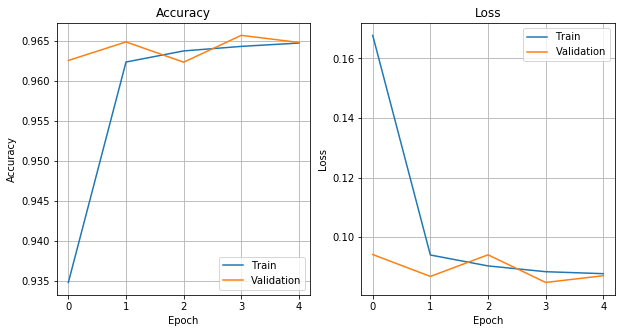

In [17]:
# read in the csv with the results
df = pd.read_csv('../../../model_checkpoints/unet_all_reshaped.csv')
plt.subplot(121)
plt.plot(df['epoch'],df['acc'], label = "Train")
plt.plot(df['epoch'],df['val_acc'],label = "Validation")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['epoch'],df['loss'], label = "Train")
plt.plot(df['epoch'],df['val_loss'],label = "Validation")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.show()

The training accuracy and loss seem to be higher than the validation loss. This is because the training error is the average over all of the samples while training the model, where as the validation is the error on the validation samples after all of the training for the epoch was done. This plot also shows that more epochs will likely not help very much since the training error and loss reach a plateau. 

### Try adding dropout

In [9]:
# Variables to tweak
epochs = 5
batch_size = 15
steps_per_epoch = round(train_size/batch_size)
validation_steps = round(validate_size/batch_size)

# define parameters to build the model
params = {
    'n_classes' : 1,
    'lr' : 0.01,
    'optimizer' : 'sgd',
    'loss': 'binary_crossentropy',
    'dropout' : 0.5,
    'conv_depth' : 64,
    'input_shape' : input_shape,
    'activation' : "relu",
    'init_w' : "he_normal",
    'output_activation': 'sigmoid'
}

trainGenParams = {
    'path' : path,
    'which_data': 'train',
    'n_classes' : 1,
    'batch_size': batch_size,
    'target_size': (256,256)
}

validateGenParams = {
    'path' : path,
    'which_data': 'validate',
    'n_classes' : 1,
    'batch_size': batch_size,
    'target_size': (256,256)
}

m_checkpoint = model_path + 'unet/unet_reshaped_dropout.hdf5'
log_checkpoint = model_path + 'unet/unet_reshaped_dropout.csv'

In [13]:
# define the callbacks
model_checkpoint = ModelCheckpoint(m_checkpoint, monitor='loss',verbose=1, save_best_only=True)
logger = CSVLogger(log_checkpoint)
# create generators and model
trainGenerator = generateData(trainGenParams)
validateGenerator = generateData(validateGenParams)
model = unet(params)

output = model.fit_generator(generator = trainGenerator,
                    validation_data = validateGenerator,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    use_multiprocessing = True,
                    callbacks =[model_checkpoint, logger])

Found 22150 images belonging to 1 classes.
Epoch 1/5
Found 22150 images belonging to 1 classes.
1476/1477 [============================>.] - ETA: 1s - loss: 0.1650 - acc: 0.9363Found 3496 images belonging to 1 classes.
Found 3496 images belonging to 1 classes.
1477/1477 [==============================] - 2149s 1s/step - loss: 0.1650 - acc: 0.9363 - val_loss: 0.0911 - val_acc: 0.9634

Epoch 00001: loss improved from inf to 0.16501, saving model to ../../model_checkpoints/unet/unet_reshaped_dropout.hdf5
Epoch 2/5
1476/1477 [============================>.] - ETA: 1s - loss: 0.0927 - acc: 0.9628Found 3496 images belonging to 1 classes.
Found 3496 images belonging to 1 classes.
1477/1477 [==============================] - 2133s 1s/step - loss: 0.0927 - acc: 0.9628 - val_loss: 0.0867 - val_acc: 0.9650

Epoch 00002: loss improved from 0.16501 to 0.09268, saving model to ../../model_checkpoints/unet/unet_reshaped_dropout.hdf5
Epoch 3/5
1476/1477 [============================>.] - ETA: 1s - los

### Train a smaller model

In [ ]:
# get length of the training and validation sets
train_size = len(os.listdir(path + '/train/data'))
validate_size = len(os.listdir(path + '/validate/data'))

# Variables to tweak
epochs = 1
batch_size = 15
steps_per_epoch = round(train_size/batch_size)
validation_steps = round(validate_size/batch_size)

# define parameters to build the model
params = {
    'n_classes' : 2,
    'lr' : 0.01,
    'optimizer' : 'sgd',
    'loss': 'binary_crossentropy',
    'dropout' : 0.5,
    'conv_depth' : 16,
    'input_shape' : input_shape,
    'activation' : "relu",
    'init_w' : "he_normal"
}

trainGenParams = {
    'path' : path,
    'which_data': 'train',
    'n_classes' : 1,
    'batch_size': batch_size,
    'target_size': (256,256)
}

validateGenParams = {
    'path' : path,
    'which_data': 'validate',
    'n_classes' : 1,
    'batch_size': batch_size,
    'target_size': (256,256)
}

In [ ]:
# define the callbacks
model_checkpoint = ModelCheckpoint('../../../model_checkpoints/unet/unet_reshaped_dropout_smaller.hdf5', monitor='loss',verbose=1, save_best_only=True)
logger = CSVLogger('../../../model_checkpoints/unet/unet_reshaped_dropout_smaller.csv')
# define the generators
trainGenerator = generateData(trainGenParams)
validateGenerator = generateData(validateGenParams)

model = unet(params)

In [ ]:
output = model.fit_generator(generator = trainGenerator,
                    validation_data = validateGenerator,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    use_multiprocessing = True,
                    callbacks =[model_checkpoint, logger])

### Train a multi-class model

In [5]:
# Variables to tweak
epochs = 1
batch_size = 10
steps_per_epoch = round(train_size/batch_size)
validation_steps = round(validate_size/batch_size)


dataPath = "/home/ubuntu/project/data/groundcover2016/"
modelPath = "/home/ubuntu/project/model_checkpoints/unet/"

classMap = {
    'maize' : 1,
    'maizevariety': 1,
    'wheat': 2,
    'mungbean':3
}

trainGenParams = {
    'path' : dataPath + "train",
    'classMap' : classMap,
    'epochs' : epochs,
    'n_classes': 4,
    'shape':(256,256),
} 

validateGenParams = {
    'path' : dataPath + "validate",
    'classMap' : classMap,
    'epochs' : epochs,
    'n_classes': 4,
    'shape':(256,256),
} 

modelParams = {
    'n_classes' : 4,
    'lr' : 0.01,
    'optimizer' : 'sgd',
    'loss': 'categorical_crossentropy',
    'dropout' : 0.5,
    'conv_depth' : 64,
    'input_shape' : input_shape,
    'activation' : "relu",
    'init_w' : "he_normal",
    'output_activation': 'softmax'
}

In [6]:
# define the callbacks
model_checkpoint = ModelCheckpoint('../../../model_checkpoints/unet/unet_multiclass.hdf5', monitor='loss',verbose=1, save_best_only=True)
#logger = CSVLogger('../../../model_checkpoints/unet/unet_multiclass.csv')
logger = WriteBatchResultsToCSV(modelPath + "multiclass_batch.csv",modelPath + "multiclass_epoch.csv",10)
# define the generators
trainGenerator = generateMultiClassBatch(batch_size,trainGenParams)
validateGenerator = generateMultiClassBatch(batch_size,validateGenParams)
# build the model
model = unet(modelParams)

/home/ubuntu/project/src/python/segmentation/unet_keras.py:127: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs,output = outputs)


In [ ]:
# fit the model
output = model.fit_generator(generator = trainGenerator,
                    validation_data = validateGenerator,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    use_multiprocessing = True,
                    callbacks =[model_checkpoint, logger])

Epoch 1/1
 8415/32815 [======>.......................] - ETA: 7:16:22 - loss: 0.3924 - acc: 0.8430